In [1]:
import os
import random
import sys
import argparse


# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast


# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.transforms import ToTensor, Resize, Normalize
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import multiprocessing
from tqdm.auto import tqdm

# Metrics
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt 

#from models import Model
#from datasets import get_data_loaders
#from train import train
#from test import evaluate, load_model

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.5.1
0.20.1


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cuda


In [3]:
import multiprocessing

num_workers = multiprocessing.cpu_count()
num_workers

12

### Preparing and loading the datset 

In [4]:
train_dir = "D:/sp_cup/dataset/train"
valid_dir = "D:/sp_cup/dataset/valid"

train_real = len(os.listdir(f"{train_dir}/real"))
train_fake = len(os.listdir(f"{train_dir}/fake"))
valid_real = len(os.listdir(f"{valid_dir}/real"))
valid_fake = len(os.listdir(f"{valid_dir}/fake"))

print(f"Training dataset size: {train_real + train_fake} (Real: {train_real}, Fake: {train_fake})")
print(f"Validation dataset size: {valid_real + valid_fake} (Real: {valid_real}, Fake: {valid_fake})")

Training dataset size: 262160 (Real: 42690, Fake: 219470)
Validation dataset size: 3072 (Real: 1548, Fake: 1524)


#### Calculate mean and std of the dataset

In [5]:

# Compute mean and std of the dataset
def compute_mean_and_std(data_dir):
    """
    Compute per-channel mean and std of the dataset (to be used in transforms.Normalize())
    """

    cache_file = "logs/mean_and_std.pt"
    if os.path.exists(cache_file):
        print(f"Reusing cached mean and std")
        d = torch.load(cache_file)

        return d["mean"], d["std"]

    ds = datasets.ImageFolder(
        data_dir, transform=transforms.Compose([transforms.ToTensor()])
    )
    dl = torch.utils.data.DataLoader(
        ds, batch_size=1, num_workers=multiprocessing.cpu_count()
    )

    mean = 0.0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing mean", ncols=80):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
    mean = mean / len(dl.dataset)

    var = 0.0
    npix = 0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing std", ncols=80):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1)) ** 2).sum([0, 2])
        npix += images.nelement()

    std = torch.sqrt(var / (npix / 3))

    # Cache results so we don't need to redo the computation
    torch.save({"mean": mean, "std": std}, cache_file)

    return mean, std


In [6]:
# training_mean, training_std = compute_mean_and_std(train_dir)

In [7]:
# print(f"Training Mean: {training_mean}, Training Std: {training_std}")

In [8]:
def get_data_loaders(train_dir, test_dir, batch_size, transform=None):
    """
    Create train and test data loaders using torchvision.datasets.ImageFolder.
    """

    # Create datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)

    # Create DataLoaders for train and test datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, test_loader

In [9]:
BATCH_SIZE = 16
HEIGHT = 128
WIDTH = 128

# Define transforms
transform = transforms.Compose([
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Get data loaders

train_loader, valid_loader = get_data_loaders(train_dir=train_dir,
                                              test_dir=valid_dir, 
                                              batch_size=BATCH_SIZE,
                                              transform=transform)

class_names = train_loader.dataset.classes
print(f"Class names: {class_names}")
class_to_idx = train_loader.dataset.class_to_idx
print(f"Class to index: {class_to_idx}")

Class names: ['fake', 'real']
Class to index: {'fake': 0, 'real': 1}


In [10]:
print(f"Dataloader: {len(train_loader)} batches of {BATCH_SIZE} images")
print(f"Dataloader: {len(valid_loader)} batches of {BATCH_SIZE} images") 
# print(next(iter(train_loader))[0].shape) -> torch.Size([16, 3, 224, 224])
# print(next(iter(valid_loader))[0].shape) -> torch.Size([16, 3, 224, 224])

Dataloader: 16385 batches of 16 images
Dataloader: 192 batches of 16 images


In [11]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch, train_labels_batch = train_features_batch.to(device), train_labels_batch.to(device)

print(train_features_batch.shape, train_labels_batch.shape)
print(train_labels_batch)
print([class_names[label] for label in train_labels_batch])

torch.Size([16, 3, 128, 128]) torch.Size([16])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
['fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3602941..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.2361221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5178571..1.323268].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


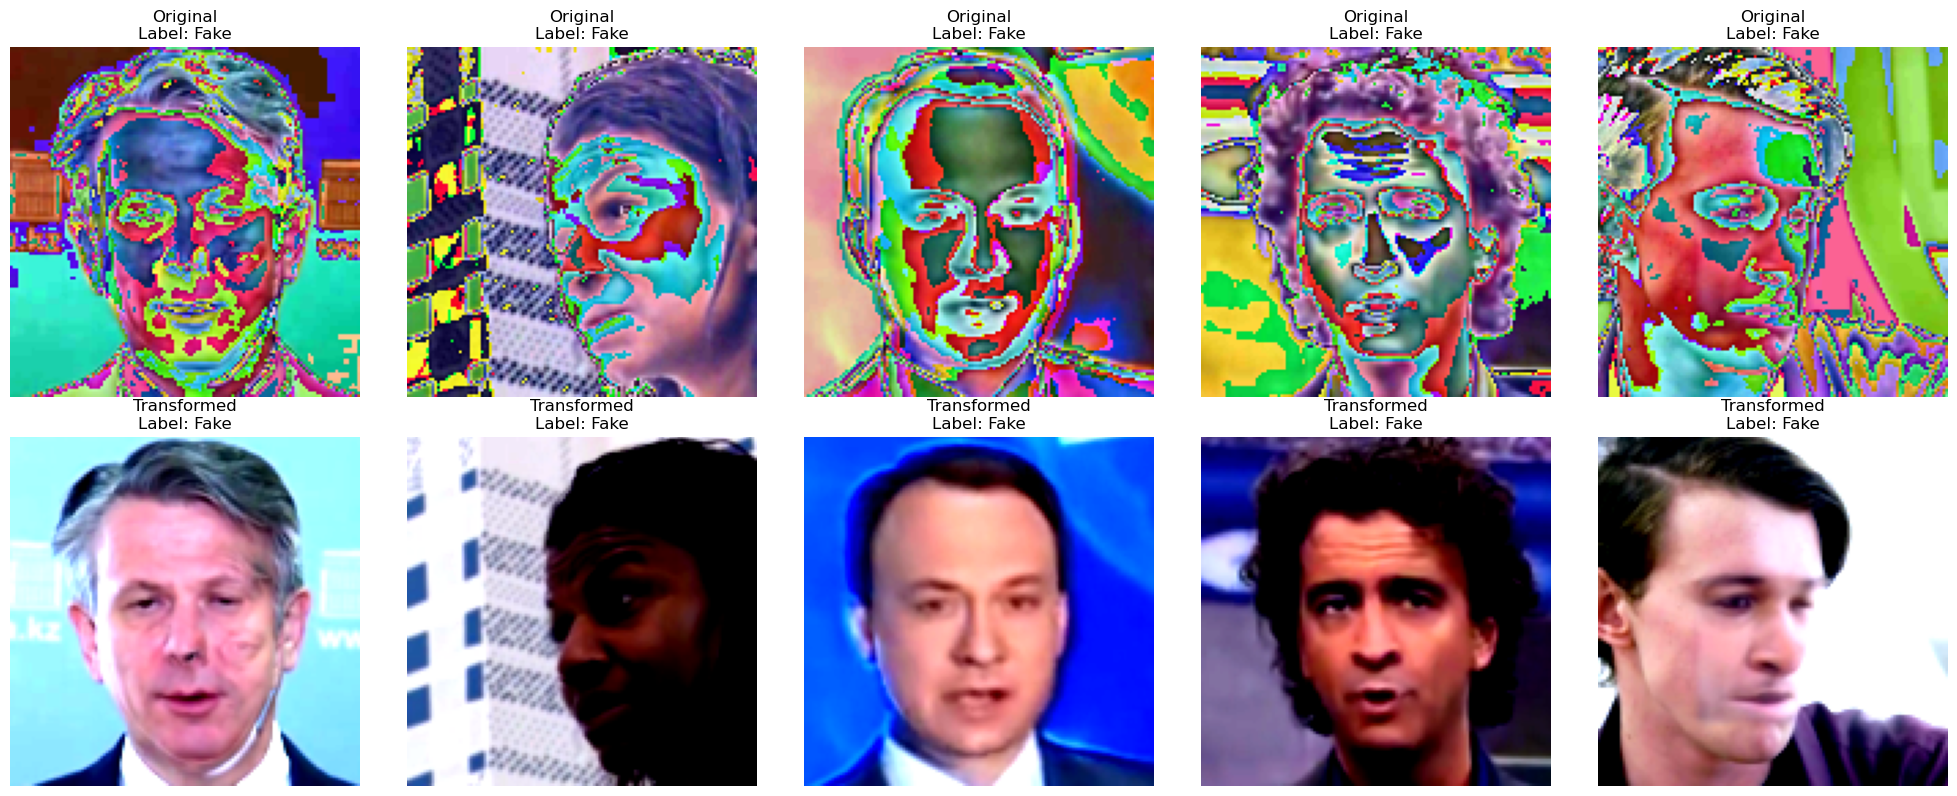

In [12]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(valid_dir, transform=transform)

# Randomly select 5 images from the balanced dataset
selected_indices = random.sample(range(len(train_dataset)), 5)

# Display 5 images before and after transform
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns


for i, idx in enumerate(selected_indices):
    image, label = train_dataset[idx]
    
    # Original image
    axes[0, i].imshow(transforms.ToPILImage()(image))
    axes[0, i].set_title(f"Original\nLabel: {'Fake' if label == 0 else 'Real'}")
    axes[0, i].axis('off')
    
    # Transformed image
    axes[1, i].imshow(image.permute(1, 2, 0) * 0.5 + 0.5)
    axes[1, i].set_title(f"Transformed\nLabel: {'Fake' if label == 0 else 'Real'}")
    axes[1, i].axis('off')


plt.tight_layout()
plt.show()

### Model

In [13]:
class FrequencyBranch(nn.Module):
    def __init__(self, output_size=128, hidden_size1=512, hidden_size2=256):
        super(FrequencyBranch, self).__init__()
        input_size = 3 * HEIGHT * WIDTH * 2
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, img):
        batch_size = img.shape[0]
        
        # Perform FFT on GPU
        f_transform = torch.fft.fft2(img)
        f_transform_shifted = torch.fft.fftshift(f_transform)
        
        # Calculate amplitude and phase on GPU
        amplitude = torch.abs(f_transform_shifted)
        phase = torch.angle(f_transform_shifted)
        
        # Flatten and concatenate
        features = torch.cat((amplitude.flatten(1), phase.flatten(1)), dim=1)
        
        # Pass through network
        x = self.relu(self.fc1(features))
        x = self.relu(self.fc2(x))
        return self.fc3(x)
    

class PreTrainedBranch(nn.Module):
    def __init__(self, input_channels=3, output_features=128):
        super(PreTrainedBranch, self).__init__()
        
        # Load pretrained EfficientNet
        self.efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(self.efficientnet.classifier[1].in_features, output_features),
        )
        
    def forward(self, x):
        x = self.efficientnet(x)
        return x


class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.freq_branch = FrequencyBranch(output_size=128)
        self.conv_branch = PreTrainedBranch(output_features=128)
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Same input for both branches
        freq_output = self.freq_branch(x)
        conv_output = self.conv_branch(x)

        combined = torch.cat((freq_output, conv_output), dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        # x = torch.sigmoid(self.fc3(x))
        return x

In [14]:
model = CombinedModel()
model.to(device)
print( next(model.parameters()).device)
# print(model)

cuda:0


In [15]:
# Ensure all parameters require gradients
#for param in model.parameters():
   # param.requires_grad = False

In [16]:
test_input = torch.randn(32, 3, HEIGHT, WIDTH).to(device)
output = model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Sample predictions:\n{output[:5].cpu().detach().numpy()}")

Input shape: torch.Size([32, 3, 128, 128])
Output shape: torch.Size([32, 1])
Sample predictions:
[[-1.2331145 ]
 [-1.567517  ]
 [-1.465911  ]
 [-0.21502604]
 [-0.35355592]]


In [17]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(params=model.parameters(),
                       lr=0.001)

In [18]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [19]:
epochs = 5
scaler = GradScaler()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")

    ### Training
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(tqdm(train_loader)):
        model.train()
        X, y = X.to(device), y.float().to(device)

        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            pred_logits = model(X).squeeze()
            loss = loss_fn(pred_logits.view(-1), y)
            # print(f"Batch: {batch} | Batch Loss: {loss.item()}")

        train_loss += loss.item() # accumulate train loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        y_pred = torch.round(torch.sigmoid(pred_logits))

        train_acc += accuracy_fn(y, y_pred)

        if batch % 100 == 0:
            # print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples.")
            torch.cuda.empty_cache()  # Clear CUDA cache to prevent memory leaks

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    print(f"\nTrain loss: {train_loss:.4f}")
    print(f"Cumulative training accuracy: {train_acc}")
### Testing
test_loss, test_acc = 0, 0
real_as_real, real_as_fake, fake_as_real, fake_as_fake = 0, 0, 0, 0
model.eval()
with torch.inference_mode():
    for i, (X_test, y_test) in enumerate(tqdm(valid_loader)):
        X_test, y_test = X_test.to(device), y_test.float().to(device)

        test_logits = model(X_test).squeeze()
        test_loss += loss_fn(test_logits, y_test.float()).item()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # correct_predictions += (test_pred.view(-1) == y_test).sum().item()
        test_acc += accuracy_fn(y_test, test_pred)

        # Ensure y_test and test_pred are still on the GPU
        fake_as_fake += ((y_test == 0) & (test_pred == 0)).sum().item()
        fake_as_real += ((y_test == 0) & (test_pred == 1)).sum().item()
        real_as_fake += ((y_test == 1) & (test_pred == 0)).sum().item()
        real_as_real += ((y_test == 1) & (test_pred == 1)).sum().item()


    test_loss /= len(valid_loader)
    test_acc /= len(valid_loader)

    print(f"Real images identified as real: {real_as_real}")
    print(f"Real images identified as fake: {real_as_fake}")
    print(f"Fake images identified as real: {fake_as_real}")
    print(f"Fake images identified as fake: {fake_as_fake}")

    print(f"Validation dataset: {valid_real + valid_fake} (Real: {valid_real}, Fake: {valid_fake})")
    print(f"\nTest loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
    print(f"\nTrain loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
------


  0%|          | 0/16385 [00:16<?, ?it/s]


Train loss: 0.3929
Cumulative training accuracy: 85.32346658529143


  0%|          | 0/192 [00:17<?, ?it/s]

Real images identified as real: 0
Real images identified as fake: 710
Fake images identified as real: 863
Fake images identified as fake: 1499
Validation dataset: 3072 (Real: 1548, Fake: 1524)

Test loss: 0.5126, Test acc: 76.0742

Train loss: 0.3929 | Train acc: 85.3235 | Test loss: 0.5126 | Test acc: 76.0742
Epoch: 1
------


  0%|          | 0/16385 [00:16<?, ?it/s]


Train loss: 0.1892
Cumulative training accuracy: 92.97909673481843


  0%|          | 0/192 [00:16<?, ?it/s]

Real images identified as real: 0
Real images identified as fake: 385
Fake images identified as real: 1227
Fake images identified as fake: 1460
Validation dataset: 3072 (Real: 1548, Fake: 1524)

Test loss: 0.3700, Test acc: 85.3841

Train loss: 0.1892 | Train acc: 92.9791 | Test loss: 0.3700 | Test acc: 85.3841
Epoch: 2
------


  0%|          | 0/16385 [00:17<?, ?it/s]


Train loss: 0.1273
Cumulative training accuracy: 95.25137320720171


  0%|          | 0/192 [00:16<?, ?it/s]

Real images identified as real: 0
Real images identified as fake: 113
Fake images identified as real: 1849
Fake images identified as fake: 1110
Validation dataset: 3072 (Real: 1548, Fake: 1524)

Test loss: 0.4037, Test acc: 82.8451

Train loss: 0.1273 | Train acc: 95.2514 | Test loss: 0.4037 | Test acc: 82.8451
Epoch: 3
------


  0%|          | 0/16385 [00:17<?, ?it/s]


Train loss: 0.1064
Cumulative training accuracy: 96.21986573085138


  0%|          | 0/192 [00:17<?, ?it/s]

Real images identified as real: 0
Real images identified as fake: 352
Fake images identified as real: 1336
Fake images identified as fake: 1384
Validation dataset: 3072 (Real: 1548, Fake: 1524)

Test loss: 0.4323, Test acc: 83.9844

Train loss: 0.1064 | Train acc: 96.2199 | Test loss: 0.4323 | Test acc: 83.9844
Epoch: 4
------


  0%|          | 0/16385 [00:16<?, ?it/s]


Train loss: 0.0893
Cumulative training accuracy: 96.85764418675618


  0%|          | 0/192 [00:16<?, ?it/s]

Real images identified as real: 0
Real images identified as fake: 481
Fake images identified as real: 1160
Fake images identified as fake: 1431
Validation dataset: 3072 (Real: 1548, Fake: 1524)

Test loss: 0.6319, Test acc: 81.3151

Train loss: 0.0893 | Train acc: 96.8576 | Test loss: 0.6319 | Test acc: 81.3151


In [20]:
from datetime import datetime
import os

# Create saved_states directory if it doesn't exist
os.makedirs("saved_states", exist_ok=True)

# Generate timestamp and filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"combined_model_{timestamp}.pth"

# Construct full path
model_save_path = os.path.join("saved_states", model_filename)

# Save model state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to saved_states\combined_model_20250112_191225.pth


In [21]:
from datetime import datetime
# model_save_path = f"deepfake_detect_model_20250110_201404.pth"

# Load the trained model
loaded_model = CombinedModel()
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.to(device)
print("Model loaded successfully")

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_10708\4124628633.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_save_path))


Model loaded successfully


In [28]:
### Testing
test_loss, test_acc = 0, 0
real_as_real, real_as_fake, fake_as_real, fake_as_fake = 0, 0, 0, 0
loaded_model.eval()
with torch.inference_mode():
    for i, (X_test, y_test) in enumerate(tqdm(valid_loader)):
        X_test, y_test = X_test.to(device), y_test.float().to(device)

        test_logits = loaded_model(X_test).squeeze()
        test_loss += loss_fn(test_logits, y_test.float()).item()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # correct_predictions += (test_pred.view(-1) == y_test).sum().item()
        test_acc += accuracy_fn(y_test, test_pred)

        # Ensure y_test and test_pred are still on the GPU
        fake_as_fake += ((y_test == 0) & (test_pred == 0)).sum().item()
        fake_as_real += ((y_test == 0) & (test_pred == 1)).sum().item()
        real_as_fake += ((y_test == 1) & (test_pred == 0)).sum().item()
        real_as_real += ((y_test == 1) & (test_pred == 1)).sum().item()


    test_loss /= len(valid_loader)
    test_acc /= len(valid_loader)

    print(f"Real images identified as real: {real_as_real}")
    print(f"Real images identified as fake: {real_as_fake}")
    print(f"Fake images identified as real: {fake_as_real}")
    print(f"Fake images identified as fake: {fake_as_fake}")

    print(f"Validation dataset: {valid_real + valid_fake} (Real: {valid_real}, Fake: {valid_fake})")
    print(f"\nTest loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")


  0%|          | 0/192 [00:16<?, ?it/s]

Real images identified as real: 1067
Real images identified as fake: 481
Fake images identified as real: 93
Fake images identified as fake: 1431
Validation dataset: 3072 (Real: 1548, Fake: 1524)

Test loss: 0.6319, Test acc: 81.3151
